# TARGET HK: Chinese State Disinformation Campaigns On Twitter

This is a quick dive into the trove of Chinese state troll tweets released by Twitter on Aug 19. In its press release, [Twitter said](https://blog.twitter.com/en_us/topics/company/2019/information_operations_directed_at_Hong_Kong.html) the tweets were from "a significant state-backed information operation focused on the situation in Hong Kong, specifically the protest movement and their calls for political change."

The tweets deserve a deeper examination, and clearly more can be done with the material. I had previously worked on a [project on uncovering such disinformation campaigns on Twitter](https://github.com/chuachinhon/twitter_state_trolls_cch).

Due to time constraints, here's a quick and dirty first exploratory look at the data. More to come in the coming days and weeks.

In [1]:
%load_ext blackcellmagic

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
from string import punctuation

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# 1. SIMPLE PRE-PROCESSING  

In [3]:
pd.set_option('display.max_columns', 40)

In [4]:
# The CSV files are too large to upload to Github. Download them directly from Twitter 
# via link above 
raw1 = pd.read_csv('../data/china_082019_1_tweets_csv_hashed.csv')
raw2 = pd.read_csv('../data/china_082019_2_tweets_csv_hashed.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (15,19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Twitter released the state troll tweets in two separate sets but noted
# that it had evidence "both sets are associated with the same entity"
# I opted to merge the two sets for this initial analysis
raw = pd.concat([raw1, raw2])

In [6]:
raw.head()

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,poll_choices
0,436306424587890688,206027550,The Flecha,nessniven,Republic of Korea,When you see Jair Bolsonaro and his program of...,NaN,100847,31752,2010-10-22,en,pt,segui o @instagranzin e ganhei 89 seguidores ♥...,2014-02-20 01:08,TweetDeck,NaN,NaN,NaN,False,NaN,NaN,absent,absent,0.0,0.0,1.0,0.0,NaN,NaN,[443196382],NaN
1,582682975969624064,206027550,The Flecha,nessniven,Republic of Korea,When you see Jair Bolsonaro and his program of...,NaN,100847,31752,2010-10-22,en,pt,10 COISAS QUE VOCÊ NÃO SABE SOBRE A VAGINA (a ...,2015-03-30 23:17,TweetDeck,NaN,NaN,NaN,False,NaN,NaN,absent,absent,0.0,0.0,0.0,52.0,[],['http://goo.gl/32K38q'],[],NaN
2,582997936541278208,206027550,The Flecha,nessniven,Republic of Korea,When you see Jair Bolsonaro and his program of...,NaN,100847,31752,2010-10-22,en,pt,QUE LEGAL! Segui o @AsPositlvidades e ele me i...,2015-03-31 20:08,TweetDeck,NaN,NaN,NaN,False,NaN,NaN,absent,absent,0.0,0.0,0.0,0.0,[],[],[116351908],NaN
3,580404049901670400,206027550,The Flecha,nessniven,Republic of Korea,When you see Jair Bolsonaro and his program of...,NaN,100847,31752,2010-10-22,en,pt,Cantora de funk de 7 anos gera polemica na int...,2015-03-24 16:21,TweetDeck,NaN,NaN,NaN,False,NaN,NaN,absent,absent,0.0,0.0,0.0,0.0,[],['http://goo.gl/iC1GM9'],[],NaN
4,199007241142149121,206027550,The Flecha,nessniven,Republic of Korea,When you see Jair Bolsonaro and his program of...,NaN,100847,31752,2010-10-22,en,NaN,QUER GANHAR SEGUIDORES FACIL? A QUANTIL QUE QU...,2012-05-06 05:26,TweetDeck,NaN,NaN,NaN,False,NaN,NaN,absent,absent,0.0,0.0,0.0,0.0,NaN,['http://migre.me/8Ycqm'],NaN,NaN


In [7]:
# There are over 3.6 million rows in this set. 
# My previous experience with this sort of data suggests that substantial filtering is needed
raw.shape

(3614909, 31)

In [8]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3614909 entries, 0 to 1708077
Data columns (total 31 columns):
tweetid                     int64
userid                      object
user_display_name           object
user_screen_name            object
user_reported_location      object
user_profile_description    object
user_profile_url            object
follower_count              int64
following_count             int64
account_creation_date       object
account_language            object
tweet_language              object
tweet_text                  object
tweet_time                  object
tweet_client_name           object
in_reply_to_userid          object
in_reply_to_tweetid         float64
quoted_tweet_tweetid        float64
is_retweet                  bool
retweet_userid              object
retweet_tweetid             float64
latitude                    object
longitude                   object
quote_count                 float64
reply_count                 float64
like_count  

In [9]:
# Dropping columns with little informational value
raw = raw.drop(
    columns=[
        "user_profile_url",
        "tweet_client_name",
        "in_reply_to_tweetid",
        "in_reply_to_userid",
        "quoted_tweet_tweetid",
        "is_retweet",
        "retweet_userid",
        "retweet_tweetid",
        "quote_count",
        "reply_count",
        "urls",
        "user_mentions",
        "poll_choices",
        "latitude", # no values in dataset beyond absent/present 
        "longitude", # no values in dataset beyond absent/present
        "like_count",
        "retweet_count"
    ]
)

In [10]:
raw.head()

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,hashtags
0,436306424587890688,206027550,The Flecha,nessniven,Republic of Korea,When you see Jair Bolsonaro and his program of...,100847,31752,2010-10-22,en,pt,segui o @instagranzin e ganhei 89 seguidores ♥...,2014-02-20 01:08,NaN
1,582682975969624064,206027550,The Flecha,nessniven,Republic of Korea,When you see Jair Bolsonaro and his program of...,100847,31752,2010-10-22,en,pt,10 COISAS QUE VOCÊ NÃO SABE SOBRE A VAGINA (a ...,2015-03-30 23:17,[]
2,582997936541278208,206027550,The Flecha,nessniven,Republic of Korea,When you see Jair Bolsonaro and his program of...,100847,31752,2010-10-22,en,pt,QUE LEGAL! Segui o @AsPositlvidades e ele me i...,2015-03-31 20:08,[]
3,580404049901670400,206027550,The Flecha,nessniven,Republic of Korea,When you see Jair Bolsonaro and his program of...,100847,31752,2010-10-22,en,pt,Cantora de funk de 7 anos gera polemica na int...,2015-03-24 16:21,[]
4,199007241142149121,206027550,The Flecha,nessniven,Republic of Korea,When you see Jair Bolsonaro and his program of...,100847,31752,2010-10-22,en,NaN,QUER GANHAR SEGUIDORES FACIL? A QUANTIL QUE QU...,2012-05-06 05:26,NaN


In [11]:
print("Unique userids", raw["userid"].nunique())
print("Unique user display names", raw["user_display_name"].nunique(),)
print("Unique user screen names", raw["user_screen_name"].nunique(), )
print("Unique user reported locations", raw["user_reported_location"].nunique(),)
print("Unique user creation dates", raw["account_creation_date"].nunique(),)
print("Unique account languages", raw["account_language"].nunique(),)
print("Unique tweet languages", raw["tweet_language"].nunique(),)
print("Unique tweet text", raw["tweet_text"].nunique(), )
print("Unique tweet time", raw["tweet_time"].nunique(), )
print("Unique hashtags", raw["hashtags"].nunique(),)

Unique userids 890
Unique user display names 883
Unique user screen names 890
Unique user reported locations 178
Unique user creation dates 427
Unique account languages 9
Unique tweet languages 59
Unique tweet text 3236991
Unique tweet time 1412732
Unique hashtags 110957


In [12]:
# removing tweets with RTs, which number 1,040,647
# RTs themselves constitute an interesting area to study, but too complicated at this stage
raw = raw[~raw['tweet_text'].str.startswith("RT @")].copy()

In [13]:
raw.shape

(2574262, 14)

In [14]:
# The top language used for the tweets is strangely enough Bahasa Indonesia..?
raw['tweet_language'].value_counts().head(10)

in     756396
en     443038
zh     138032
und     92043
ar      76906
es      67413
tl      30012
pt      26040
ja       9116
et       9082
Name: tweet_language, dtype: int64

In [15]:
# filtering out tweets only for English and Chinese tweet text
raw = raw[(raw['tweet_language'] == 'en') | (raw['tweet_language'] == 'zh')].copy()

In [16]:
# further significant drop in number of tweets after filtering out non-English 
# and non-Chinese tweets. 1,993,192 tweets were dropped
raw.shape

(581070, 14)

# 2. QUINTIESSENTIAL CHINESE STATE TWEETS TARGETTING HK

Let's get a quick flavour of what these Chinese state tweets look like, in both English and Chinese.

In [17]:
# Quick check on English key words associated with HK protests, prior to using NLP tools later
key_words1 = raw[raw['tweet_text'].str.contains('hong kong')]
key_words2 = raw[raw['tweet_text'].str.contains('Hong Kong')]
key_words3 = raw[raw['tweet_text'].str.contains('protest')]
key_words4 = raw[raw['tweet_text'].str.contains('activists')]
key_words5 = raw[raw['tweet_text'].str.contains('anti-extradition')]
key_words6 = raw[raw['tweet_text'].str.contains('China')]

In [18]:
key_words2['tweet_text'].sample(50).values

array(['Fleetwood two shots off the lead in Hong Kong https://t.co/3znymqYmDp',
       'Obviously, first there were agents on the scene to direct and disrupt Hong Kong, and then the us government came forward to accuse and sanction Hong Kong. These agents exerted pressure on China and Hong Kong government by spreading negative information about Hong Kong. #HK https://t.co/Q6dGQUUHoG',
       'maomao_army: RT sooyeon_fashion: 170213 Hong Kong Airport\nBLANC &amp; ECLARE: New York Sunglasses (Black), $260 … https://t.co/i56bccHc3G',
       "And as a media, @BBCWorld don't report facts in a fair way. It is clear that you are politically biased and not in line with public opinion in Hong Kong.",
       'Hong Kong Open: Wade Ormsby wins first European Tour title https://t.co/5fR9WnNY6U',
       "Hong Kong Disneyland is razing Sleeping Beauty's Castle — and putting in something AMAZING… https://t.co/nGmHp6yIyk",
       "Hong Kong Disneyland is razing Sleeping Beauty's Castle — and putting in

## Samples of state troll tweets with key words "Hong Kong":

- '外國勢力策反香港政府嘅12個步驟【2】\nThe 12 steps taken by foreign forces to overthrow the Hong Kong government【2】\n#香港 #顏色革命 #外國勢力 #香港時政直擊 https://t.co/U1e4aeuxpm',

- 'The Hong Kong police have tolerated, restrained and maintained the soul of the disciplined forces. They are still worthy of one of the most professional and outstanding police agencies in the world. https://t.co/AV14k7VVAn',

- 'The legislative council belongs to the people of Hong Kong.Those people with ulterior motives indicated by forces hide behind the scenes laid siege to the legislative.The path of your darkness and the bright roads of the masses of the Hong Kong people will not inevitably coexist. https://t.co/yz5JoXGLht',

- '@ahdee1004 @initiumnews This is the fact. As a Hong Kong person, I have the right to speak for Hong Kong. You are not aware of the actual situation in Hong Kong. As a media person and a Hong Kong person, I have the power to speak the truth on behalf of Hong Kong!',

- '@ctcc507 The actions of radical demonstrators are obvious to everyone in Hong Kong. The selective reporting of the media and news is also clear to the people of Hong Kong. It is not difficult to judge who is the destroyer of social order and democracy and the rule of law.'

In [19]:
# Quick check on Chinese key words associated with HK protests, prior to using NLP tools later
ch_words1 = raw[raw['tweet_text'].str.contains('香港')]
ch_words2 = raw[raw['tweet_text'].str.contains('反修例暴動')]
ch_words3 = raw[raw['tweet_text'].str.contains('反华势力')]
ch_words4 = raw[raw['tweet_text'].str.contains('外國勢力')]
ch_words5 = raw[raw['tweet_text'].str.contains('中国')]
ch_words6 = raw[raw['tweet_text'].str.contains('警察')]

In [20]:
ch_words1.sample(50).values

array([[1118681406442393600, '122337743', 'Makey', 'charikamci',
        'Long Beach, CA', nan, 29089, 5619, '2010-03-12', 'zh-tw', 'zh',
        '來自工商、法律、科技、基層等多個界別的香港市民成立「萬眾同聲撐修例公義組」，發起「護港安全撐修例大聯署」活動。「公義組」於赴特區政府總部遞交請願信，呼籲香港市民通過網上或親身簽署等方式，聯署支援特區政府修訂《逃犯條例》，期待修例如期通過，避免香港淪為犯罪分子逃避法律責任之地。 https://t.co/BGMbswUJ0M',
        '2019-04-18 01:03', '[]'],
       [1153489145529942016, '58615166', '流金岁月', 'Licuwangxiaoyua',
        'USA', 'Licu', 13915, 13081, '2009-07-20', 'zh-cn', 'zh',
        '绝不能让暴力、歪曲文化污染香港下一代，那样受害的只会是香港自己。', '2019-07-23 02:16', '[]'],
       [1142686870104629249, '2993185258', 'HK時政直擊', 'HKpoliticalnew',
        'Tsuen Wan District, Hong Kong',
        "Love Hong Kong, love China.We should pay attention to current policies and people's livelihood. 愛港、愛國，關注時政、民生。",
        22551, 66, '2015-01-22', 'zh-cn', 'zh',
        '呢張圖講出我心聲👍\n\n#香港 #反修例暴徒 #超人 #蝗蟲 https://t.co/7XF27Q3jDz',
        '2019-06-23 06:52', "['香港', '反修例暴徒', '超人', '蝗蟲']"],
       [1110389553871781889, '243765069

## Samples of state troll tweets with Chinese key words "香港(Hong Kong)":

- '暴徒只会借着游行破坏法治、搞乱香港，不能任由他们继续为所欲为。',

- '隨着近年國家發展步伐急促，香港機遇和優勢不單只局限於香港，而是延伸至整個粵港澳大灣區。香港有漂亮維多利亞港、完善從商條件，加上祖國對香港的重視，而且對我們香港人的訴求特別關注，無論我們有什麼要求，只要合情合法，中央政府都總是允許、答應我們。 https://t.co/Gb7MSMH42n',

- 'Love Hong Kong, love China.We should pay attention to current policies and people's livelihood. 愛港、愛國，關注時政、民生。',

- '@Hehe802 外部势力干预香港政制发展进程的证据确凿，希望大家擦亮眼，认清真相，不要再做扰乱香港正常社会秩序的事情了。',

- '#HongKong #HK 香港激进反对派不是在谋整个香港社会的福祉，而是出于政治私利与西方反华势力沆瀣一气。他们为了自己的目的把一些老百姓变成他们攫取影响力的炮灰，不惜毁掉香港市民福祉赖以产生的环境，必须要认清这些势力的险恶用心。 https://t.co/yLkdb3Be8C'

In [21]:
ch_words6.sample(50).values

array([[956352452005003264, '908589031944081408', '如果', 'bagaudinzhigj',
        nan, nan, 43358, 102, '2017-09-15', 'zh-cn', 'zh',
        '#余文生 别开口就说你是"弱者"。你阻碍警察执法一点都不弱；也别圣母心泛滥说别人是弱者，再弱的人拿把刀也能把人捅死。法律面前人人平等，你自认为是弱者更应该遵守法律。https://t.co/trTsZlnSxX … https://t.co/jWcC2lyItb',
        '2018-01-25 02:26', "['余文生']"],
       [1149245251669774336, '58615166', '流金岁月', 'Licuwangxiaoyua',
        'USA', 'Licu', 13915, 13081, '2009-07-20', 'zh-cn', 'zh',
        '力挺香港警察，维护香港安宁。', '2019-07-11 09:13', '[]'],
       [960741572185874432, '1454274516', '熏君', 'nkisomekusua', nan, 's',
        33421, 1763, '2013-05-24', 'zh-cn', 'zh',
        '#桂民海 在某些人眼里，只要有一个所谓的“异议人士”的标签，似乎就真的享受着逃避法律制裁的特权。就可以酒驾撞人，可以不遵守所在国家的法律，可以避免被警察带走调查，真的可笑。',
        '2018-02-06 05:06', "['桂民海']"],
       [982402771952386048, '913223690317316096', '孟婆卖萌不卖汤',
        'homerbros7780', nan, '孟婆不仅会煮汤，还会各种美食哦！', 76718, 163,
        '2017-09-28', 'zh-cn', 'zh',
        '香港警察被文贵黑了 https://t.co/jQvMAuWi0k 来自 @YouTube',
        '2018-04-06

## Samples of state troll tweets with Chinese key words "警察(police)":

- '香港唔可以失去秩序，咁樣只會俾犯罪分子有可乘之機，呢樣嘢關係到香港人嘅切身利益，香港人需要以清晰既視角審視《逃犯條例》既本質，唔好喺他人煽風點火之下人人自危。#香港警察 #警察 #香港 https://t.co/cDzEf9TYs9',

- '@emmalinelai5 @xssx7898 香港警察維護法律尊嚴、守護社會公義',

- '#民陣 \n香港警察，好样的，我们挺你！你们的苦，我们都懂！加油！ https://t.co/eCotUJJarn',

- '當警方在處理爭執，護送涉事者離場時，只見狂徒發難，爆粗包圍，更以「黑警」辱罵執法者！試問香港警察還有尊嚴可言？倘不追究狂徒，又會否助長辱警之歪風？',

- '對於香港人嚟講，香港從嚟都系自由之港，但絕唔系法外之地，更加唔系陰謀家嘅天堂！支持香港警察'

## NOTE: 
Clearly some NLP techniques on the Chinese text would do a better job here. But I lack experience in this area. More on that later when I've had the chance to use [Stanford NLP](https://stanfordnlp.github.io/stanfordnlp/).

# 3. PARSING KEY ACCOUNT/TWEETS ATTRIBUTES

In [22]:
# top 10 users and their display/screen names
raw['user_display_name'].value_counts().head(10)

曲剑明               54455
阿丽木琴              46600
Klausv            34451
春天里               17989
gwalcki4          17707
emiliya naum      16230
derrickmc         16163
Lily Mann         14673
炫彩                14604
mauricerowleyx    11749
Name: user_display_name, dtype: int64

In [23]:
# top 10 users and their display/screen names
raw['user_screen_name'].value_counts().head(10)

qujianming1        54455
SamanthxBerg       46600
klausv02           34451
RanvijaySowle      17989
ingaibragimova1    17707
emiliya_naum       16230
derrickmcnabbx     16163
lily__mann         14673
SheldonxLill       14604
mauricerowleyx     11749
Name: user_screen_name, dtype: int64

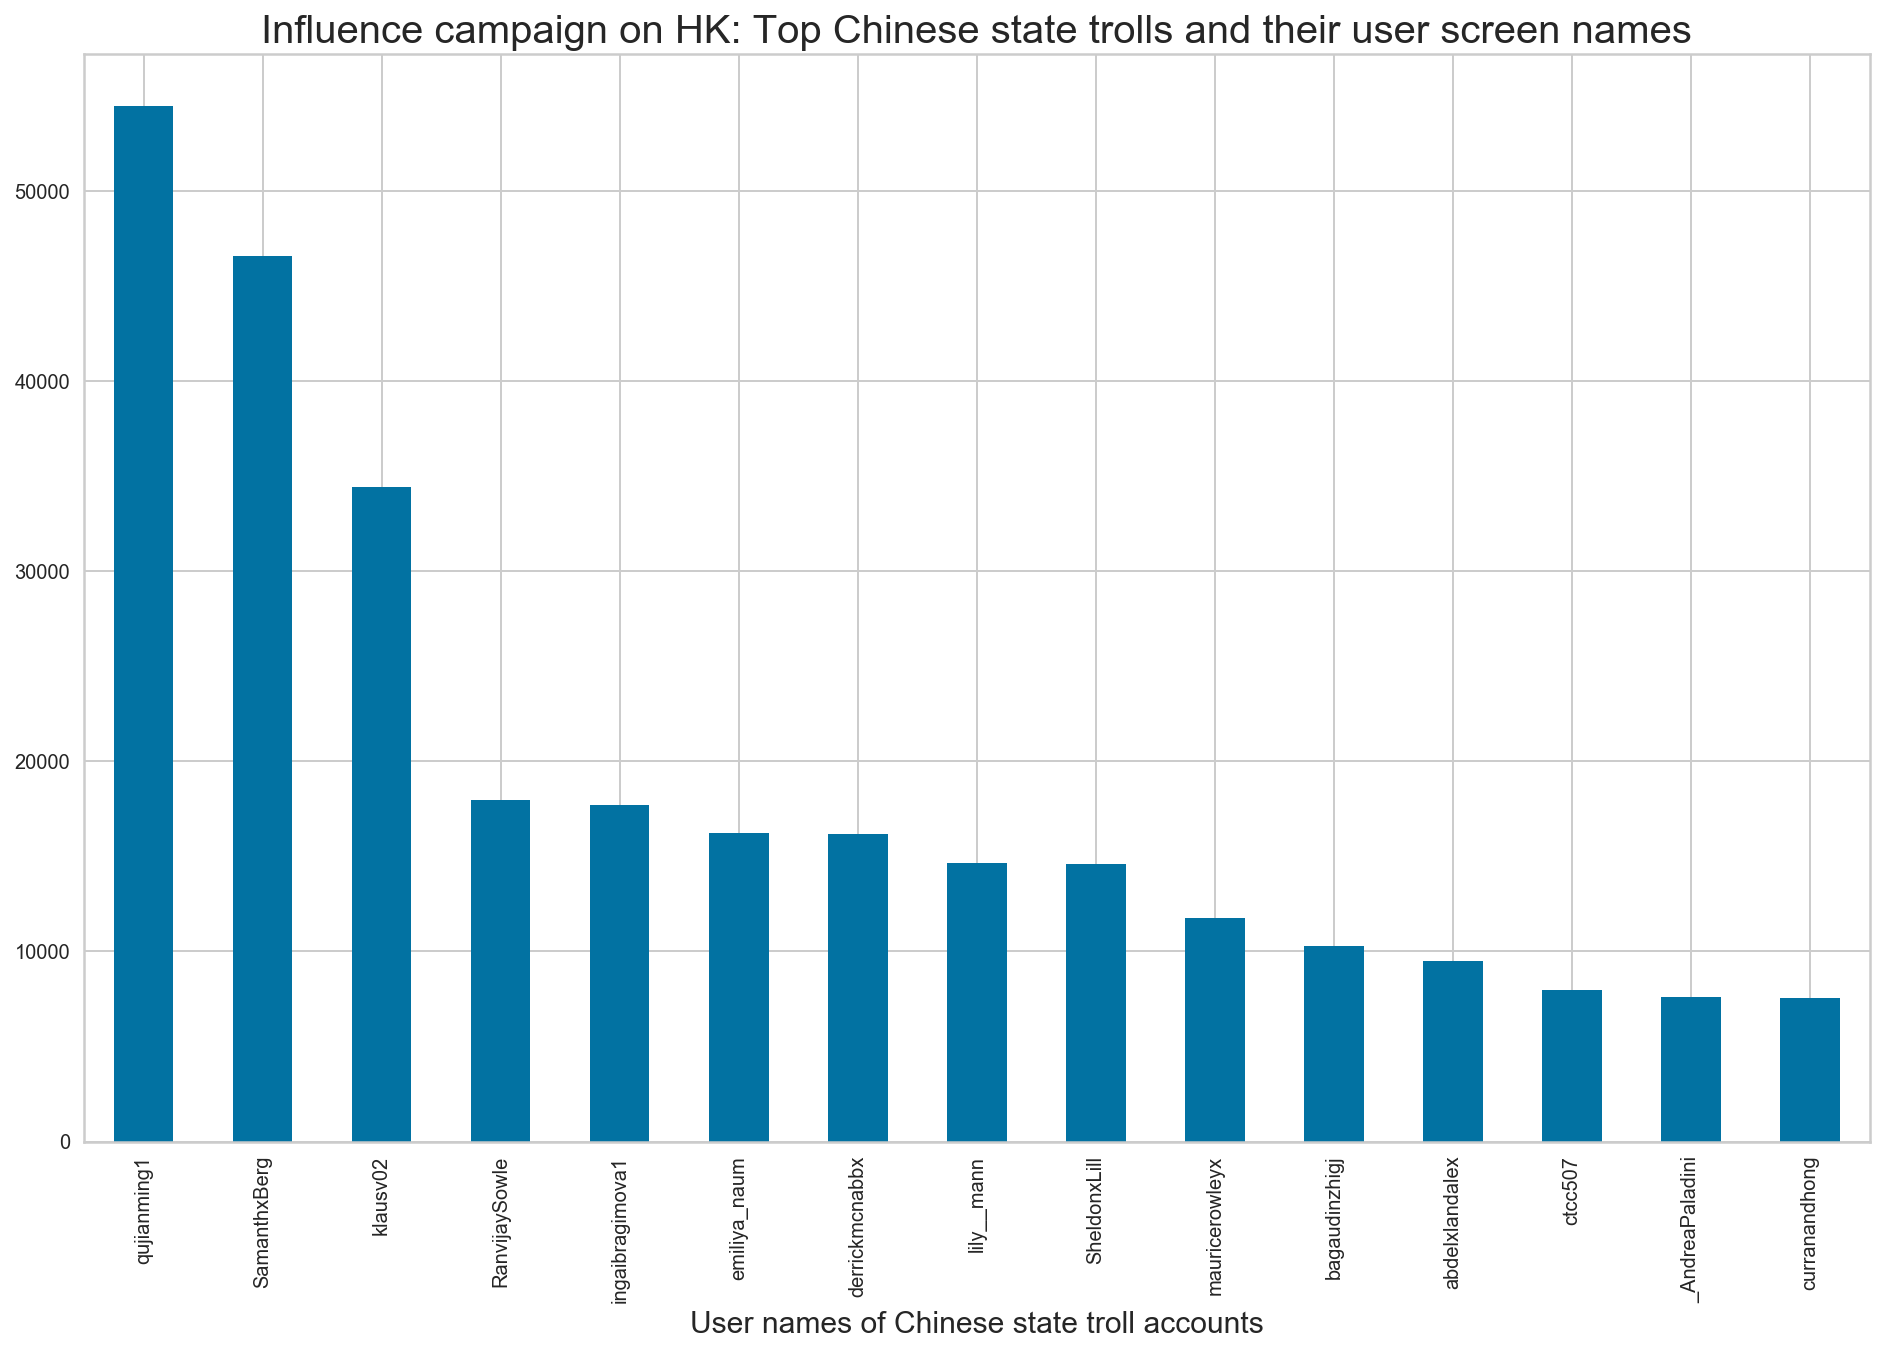

In [24]:
raw['user_screen_name'].value_counts().head(15).plot(kind='bar', figsize=(16,10))
plt.title('Influence campaign on HK: Top Chinese state trolls and their user screen names', fontsize=20)
plt.xlabel("User names of Chinese state troll accounts", fontsize=15)
plt.show()

## 3.1 TOP STATE TROLL ACCOUNT - qujianming, or 曲剑明
Let's have a look at the account which appeared most frequently in our filtered dataset. 

In [25]:
qujianming = raw[raw['user_display_name'] == '曲剑明']

In [26]:
qujianming.head()

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,hashtags
15,587625750636822528,620912741,曲剑明,qujianming1,纽约布朗克斯,一个因言获罪的流浪者，我坚信光明一定会到来。,28405,24079,2012-06-28,zh-cn,en,Test,2015-04-13 14:37,[]
16,915099864521834497,620912741,曲剑明,qujianming1,纽约布朗克斯,一个因言获罪的流浪者，我坚信光明一定会到来。,28405,24079,2012-06-28,zh-cn,en,new owner 💕,2017-10-03 06:23,[]
26,802911206134550528,620912741,曲剑明,qujianming1,纽约布朗克斯,一个因言获罪的流浪者，我坚信光明一定会到来。,28405,24079,2012-06-28,zh-cn,en,Makin gembrot. Amin https://t.co/EIwjBoUAPV,2016-11-27 16:25,[]
29,445070245011542016,620912741,曲剑明,qujianming1,纽约布朗克斯,一个因言获罪的流浪者，我坚信光明一定会到来。,28405,24079,2012-06-28,zh-cn,en,"#openfollow for rp,retweet",2014-03-16 05:33,['openfollow']
46,598854583281004544,620912741,曲剑明,qujianming1,纽约布朗克斯,一个因言获罪的流浪者，我坚信光明一定会到来。,28405,24079,2012-06-28,zh-cn,en,Test,2015-05-14 14:17,[]


In [27]:
qujianming['tweet_text'].nunique()

19614

In [28]:
# Filtering for this account's unique tweets in 2019
qujianming_2019 = qujianming[qujianming['tweet_time'].str.contains('2019')]
qujianming_2019['tweet_text'].nunique()

77

### NOTE: ON qujianming, or 曲剑明
This troll account sent out 19,614 unique tweets in my filtered dataset. The account was created on June 28 2012, and has 28,405 followers and follows 24079 users - a suspiciously high number and a major tell-tale sign of a troll account.

The account tweeted 77 times in 2019. Some samples:
- 2019-07-05: '香港作为一个法治社会的典范，这种暴徒行径一定要严惩，换民众一个公道'

- 2019-07-04: '反对势力想尽办法想搞乱香港，想等混乱的时候谋取利益，他们根本就无暇顾及市民的利益，可怜的是还...'

- 019-07-02: '#HongKongProtest #香港 #七一 #游行 #民阵 7月1日反对派宣扬暴力冲击...'

## 3.2 STATE TROLL ACCOUNT HIGHLIGTED BY TWITTER - HKpoliticalnew, or HK時政直擊
Next, let's look at the account which was featured in Twitter's announcement of the Chinese disinformation campaign. 

In [29]:
HKpoliticalnew = raw[raw['user_display_name'] == 'HK時政直擊']

In [30]:
HKpoliticalnew.head()

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,hashtags
1904732,1140281288009637888,2993185258,HK時政直擊,HKpoliticalnew,"Tsuen Wan District, Hong Kong","Love Hong Kong, love China.We should pay atten...",22551,66,2015-01-22,zh-cn,en,@ahdee1004 @initiumnews This is the fact. As a...,2019-06-16 15:33,[]
1904733,1140289573752360960,2993185258,HK時政直擊,HKpoliticalnew,"Tsuen Wan District, Hong Kong","Love Hong Kong, love China.We should pay atten...",22551,66,2015-01-22,zh-cn,en,@ahdee1004 @initiumnews OK，You can go to Faceb...,2019-06-16 16:06,[]
1904736,1140079659385806848,2993185258,HK時政直擊,HKpoliticalnew,"Tsuen Wan District, Hong Kong","Love Hong Kong, love China.We should pay atten...",22551,66,2015-01-22,zh-cn,zh,@MuGuang001 唔知啊，我也想問邊度嚟嘅咁多大陸仔,2019-06-16 02:12,[]
1904737,1008183685932244992,2993185258,HK時政直擊,HKpoliticalnew,"Tsuen Wan District, Hong Kong","Love Hong Kong, love China.We should pay atten...",22551,66,2015-01-22,zh-cn,en,"@SteakWang @rogerfederer Love you very much, a...",2018-06-17 03:04,[]
1904738,1139838959482068993,2993185258,HK時政直擊,HKpoliticalnew,"Tsuen Wan District, Hong Kong","Love Hong Kong, love China.We should pay atten...",22551,66,2015-01-22,zh-cn,zh,@2GMV9K4cu1odROy @Michaelwuguilin 喺過去一周時間，從放出「...,2019-06-15 10:15,[]


In [31]:
HKpoliticalnew['tweet_text'].nunique()

1059

In [32]:
# Filtering for this account's unique tweets in 2019
HKpoliticalnew = HKpoliticalnew[HKpoliticalnew['tweet_time'].str.contains('2019')]
HKpoliticalnew['tweet_text'].nunique()

462

In [33]:
HKpoliticalnew['tweet_text'].values

array(['@ahdee1004 @initiumnews This is the fact. As a Hong Kong person, I have the right to speak for Hong Kong. You are not aware of the actual situation in Hong Kong. As a media person and a Hong Kong person, I have the power to speak the truth on behalf of Hong Kong!',
       '@ahdee1004 @initiumnews OK，You can go to Facebook to see for yourself.',
       '@MuGuang001 唔知啊，我也想問邊度嚟嘅咁多大陸仔',
       '@2GMV9K4cu1odROy @Michaelwuguilin 喺過去一周時間，從放出「法官也反修例」消息、策動「全港學校聯署」、發動法律界「黑衣游行」，以及6月9日嘅反修例大游行、6月12日嘅反修例暴動，乃至系周日將上演嘅又一場大規模游行，都能睇到美國人嘅影子。',
       '@shenzan1226 Thank you for following me @12fnXNOpp1j+gNAYnwAyskF+6MogejqmkKzg74ovVwc=',
       '@Michaelwuguilin @ChinaManjgdgi 很多大陸仔翻牆出嚟就系為了鬧中國，嘲笑自己嘅國家，有句話講嘅好「食人家嘅飯，砸人家嘅鍋」，講嘅就系呢種無父無母嘅人。',
       '@urjscmpzslw 郭文贵的丧钟已然敲响！', '@Ericswuliang 嚴懲暴徒，才能體現法律之威嚴！',
       '@Mentimins Thank you for following me @12fnXNOpp1j+gNAYnwAyskF+6MogejqmkKzg74ovVwc=',
       '@Mentimins Thank you, and I agree with you！',
       '@Mentimins Maybe it’s democratic, but A

### NOTE: ON HKpoliticalnew, or HK時政直擊
This troll account sent out just 1,059 unique tweets in my filtered dataset. The account was created on January 22 2015, and has 22,551 followers and follows 66 users. The move to co-opt the identity of a news outfit is straight out of Russia's Internet Research Agency's playbook.

The account sent 462 "original tweets" in 2019, many of them aimed at the HK protests. Some samples:
- 2019-06-21: '千名黑衣人圍堵立會，當中不乏重裝上陣的人，警方一定要嚴防，大家小心！👍💪\n\n#香港 #大專學界 #升級行動 #包圍立會 #重裝上陣 #警察 \n原圖：星島日報 https://t.co/DIoiFWWkBo'

- 2019-06-20: '#香港 反對派一再散布失實資訊抹黑修例、誤導市民，更不斷造謠煽動情緒，企圖以網民壓力杯葛支持修例甚至只是沉默的商戶。\n政府決定停止修例工作後，反對派又繼續播謠，稱換領智能身份證會「失去選民資格」，企圖撕裂市民對社會不同界別、團體、組織的信任。 https://t.co/9B3xCI9MWv'

- 2019-06-20: '反修例暴動後，#香港 仿佛又回到占中時期嘅黑暗日子，最令人痛心嘅系，執法者又再次成為黃營發泄嘅對象，黑警，「警你老x」等言詞唔絕於意，立志以生命守護人民，卻落得過街老鼠嘅下場…\n\n立法會議員何君堯律師呼吁各位市民站出嚟山席撐警集會，為 #警察 打氣，讓佢哋知，黃營所言非香港嘅主流聲音！ https://t.co/yDpKt0mSAM' 

## 3.3 SELF-PROCLAIMED LOCATION OF STATE TROLL ACCOUNTS
Again, like the Russian state trolls, the Chinese accounts primarily claimed to be in the US.

In [34]:
raw['user_reported_location'].value_counts().head(10)

纽约布朗克斯                         54455
United States                  42737
Manhattan, NY                  35531
Georgia, USA                   22220
Los Angeles, CA                18368
California, USA                18291
Portland, OR                   17989
Texas                          14673
Worldwide, now mainly Italy     7582
Lubbock, TX                     6532
Name: user_reported_location, dtype: int64

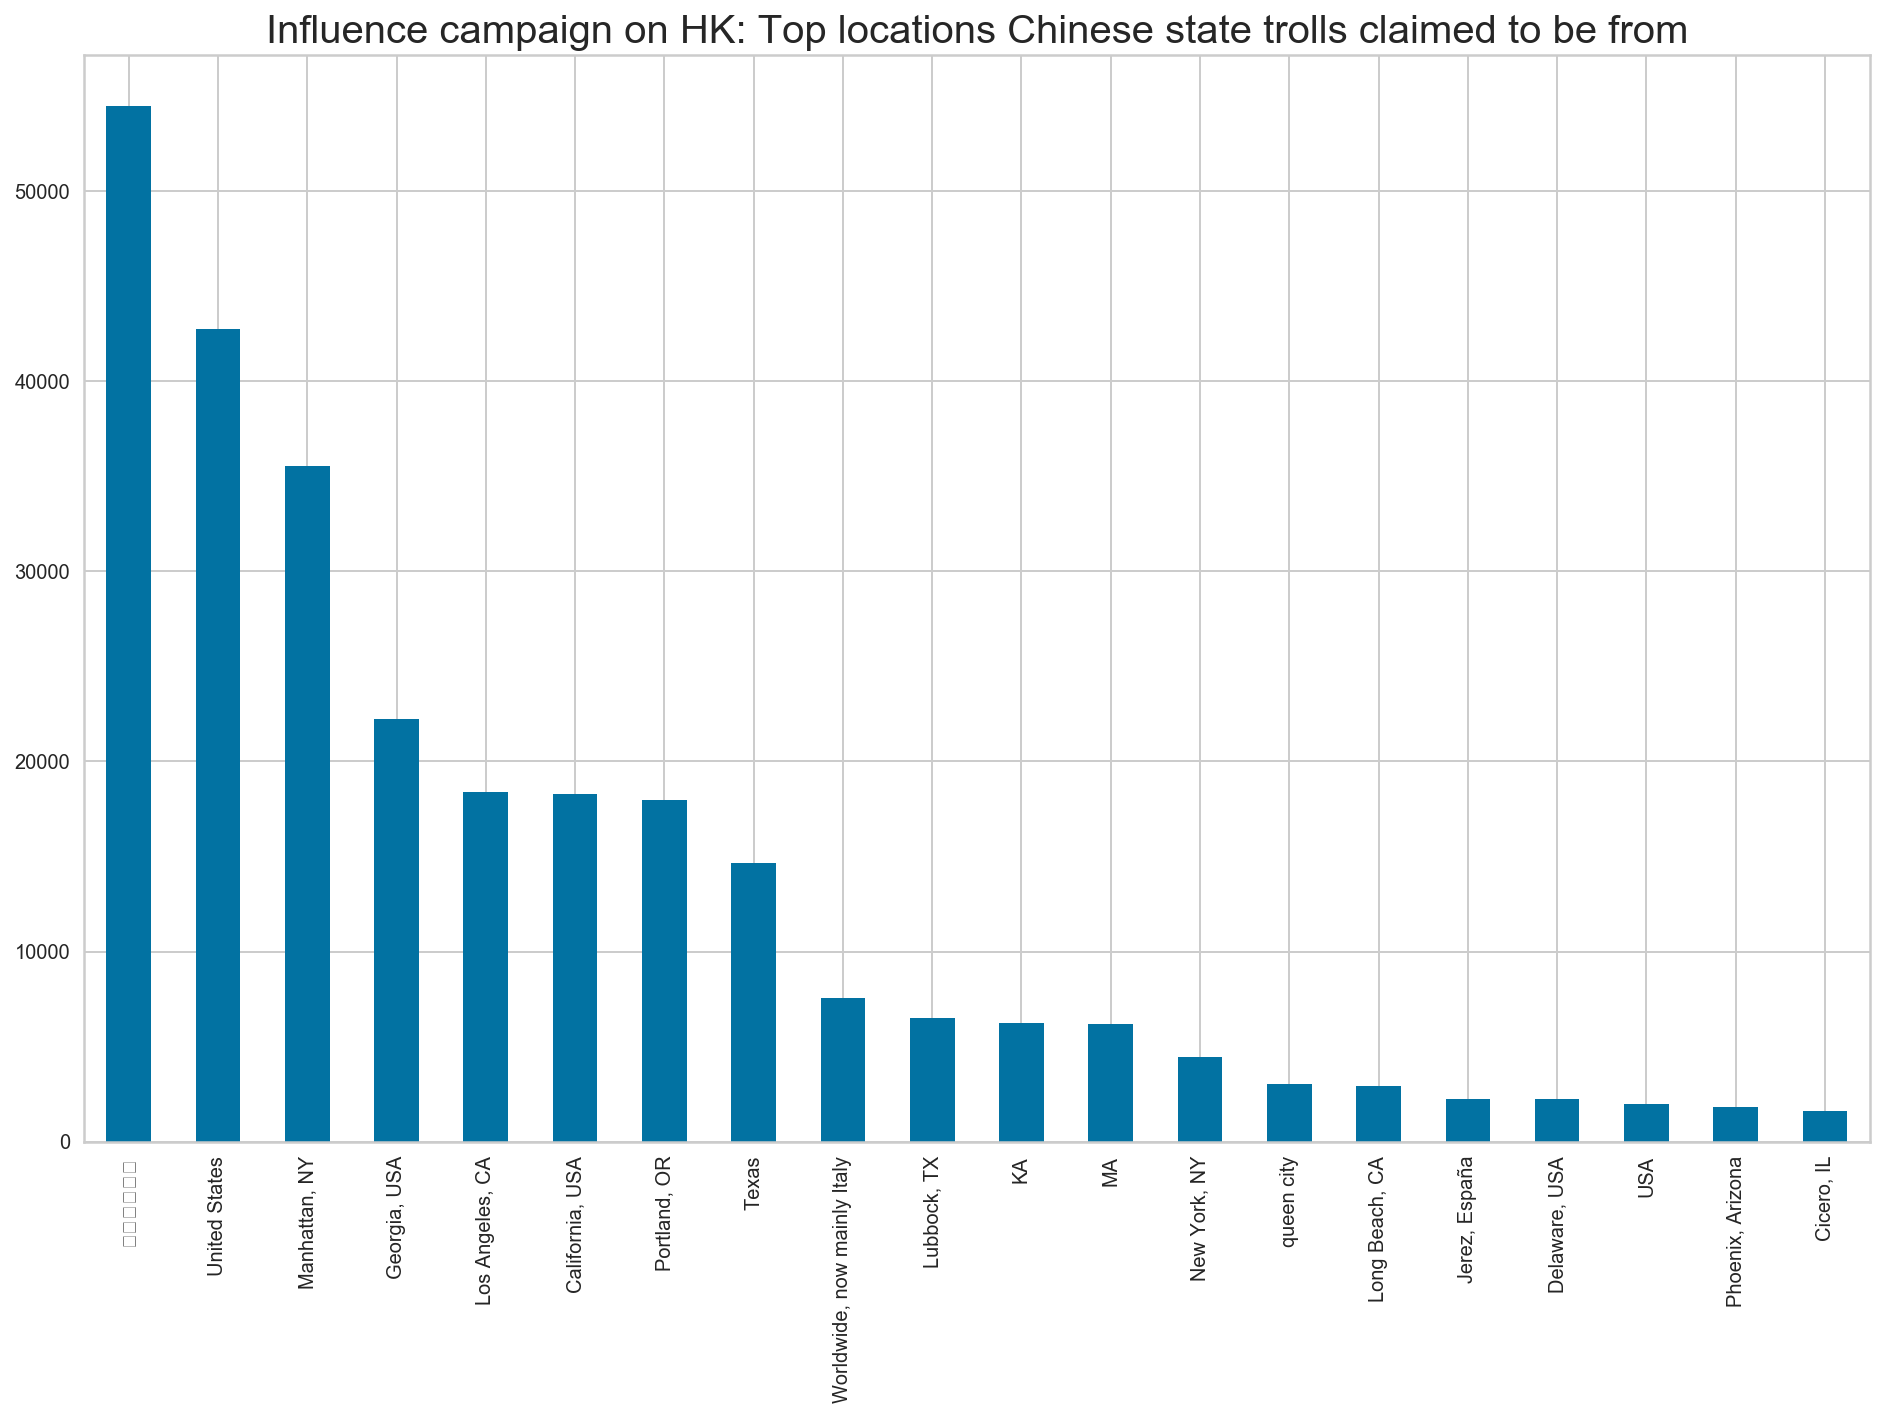

In [35]:
raw['user_reported_location'].value_counts().head(20).plot(kind='bar', figsize=(16,10))
plt.title('Influence campaign on HK: Top locations Chinese state trolls claimed to be from', fontsize=20)
plt.show()

### NOTE:
[Twitter said](https://blog.twitter.com/en_us/topics/company/2019/information_operations_directed_at_Hong_Kong.html) the accounts originated from "within the People’s Republic of China", but the top troll accounts almost claimed to be from the US - a tactic that has been used by Russian state disinformation campaigns in the run up to the 2016 US Presidential election. 

In [36]:
# The definition of "account_language" is not crystal clear, but I assume it to be a form of setting on the account.
# Here, it shows the vast majority to be set to Chinese (zh-cn, zh-CN, zh-tw)
raw['account_language'].value_counts()

zh-cn    364854
en       159626
zh-CN     47954
zh-tw      4069
es         2811
ja          765
en-gb       676
ru          302
fr           13
Name: account_language, dtype: int64

## 3.4 HASHTAGS 
Interestingly, hashtags did not feature that prominently in the state troll tweets. 

In [37]:
raw['hashtags'].value_counts().head(100)

[]                                            453846
['ptl']                                         9486
['WTL']                                         6282
['wtl']                                         6028
['整点报时']                                        5917
['tlrp']                                        5718
['pltl']                                        4662
['RTL']                                         4581
['rtl']                                         4017
['nrp']                                         1992
['TopNewFollowers']                             1903
['郭文贵']                                         1615
['HarryMeetShalanna']                           1148
['桂民海']                                          944
['PTL']                                          855
['senpaiBot']                                    837
['TLRP']                                         821
['rptl']                                         818
['JeyDice']                                   

# 4. PARSING TEMPORAL FACTORS 
This was a key tell-tale sign when identifying the Russian state influence campaigns on the US, where a large number of accounts were created in 2014. Let's see if there's a similar trend here.

## 4.1. YEAR-MONTH OF ACCOUNT CREATION

In [38]:
raw['account_creation_date'] = pd.to_datetime(raw['account_creation_date'], yearfirst=True)

In [39]:
raw['year_of_account_creation'] = raw['account_creation_date'].dt.year
raw['month_of_account_creation'] = raw['account_creation_date'].dt.month
raw['day_of_account_creation'] = raw['account_creation_date'].dt.day

In [40]:
# Most of the troll accounts in my filtered set were created in August 2017
# Could this have been inspired by the success of the Russian campaigns?
raw.groupby(['year_of_account_creation', 'month_of_account_creation']).userid.nunique().sort_index(ascending=False)

year_of_account_creation  month_of_account_creation
2019                      5                              2
                          4                              3
                          3                              2
                          2                             12
                          1                              7
2018                      12                             9
                          11                             1
                          10                             8
                          8                              1
                          7                             13
                          4                              5
                          3                              8
                          2                              2
                          1                              2
2017                      12                             5
                          11                            46
    

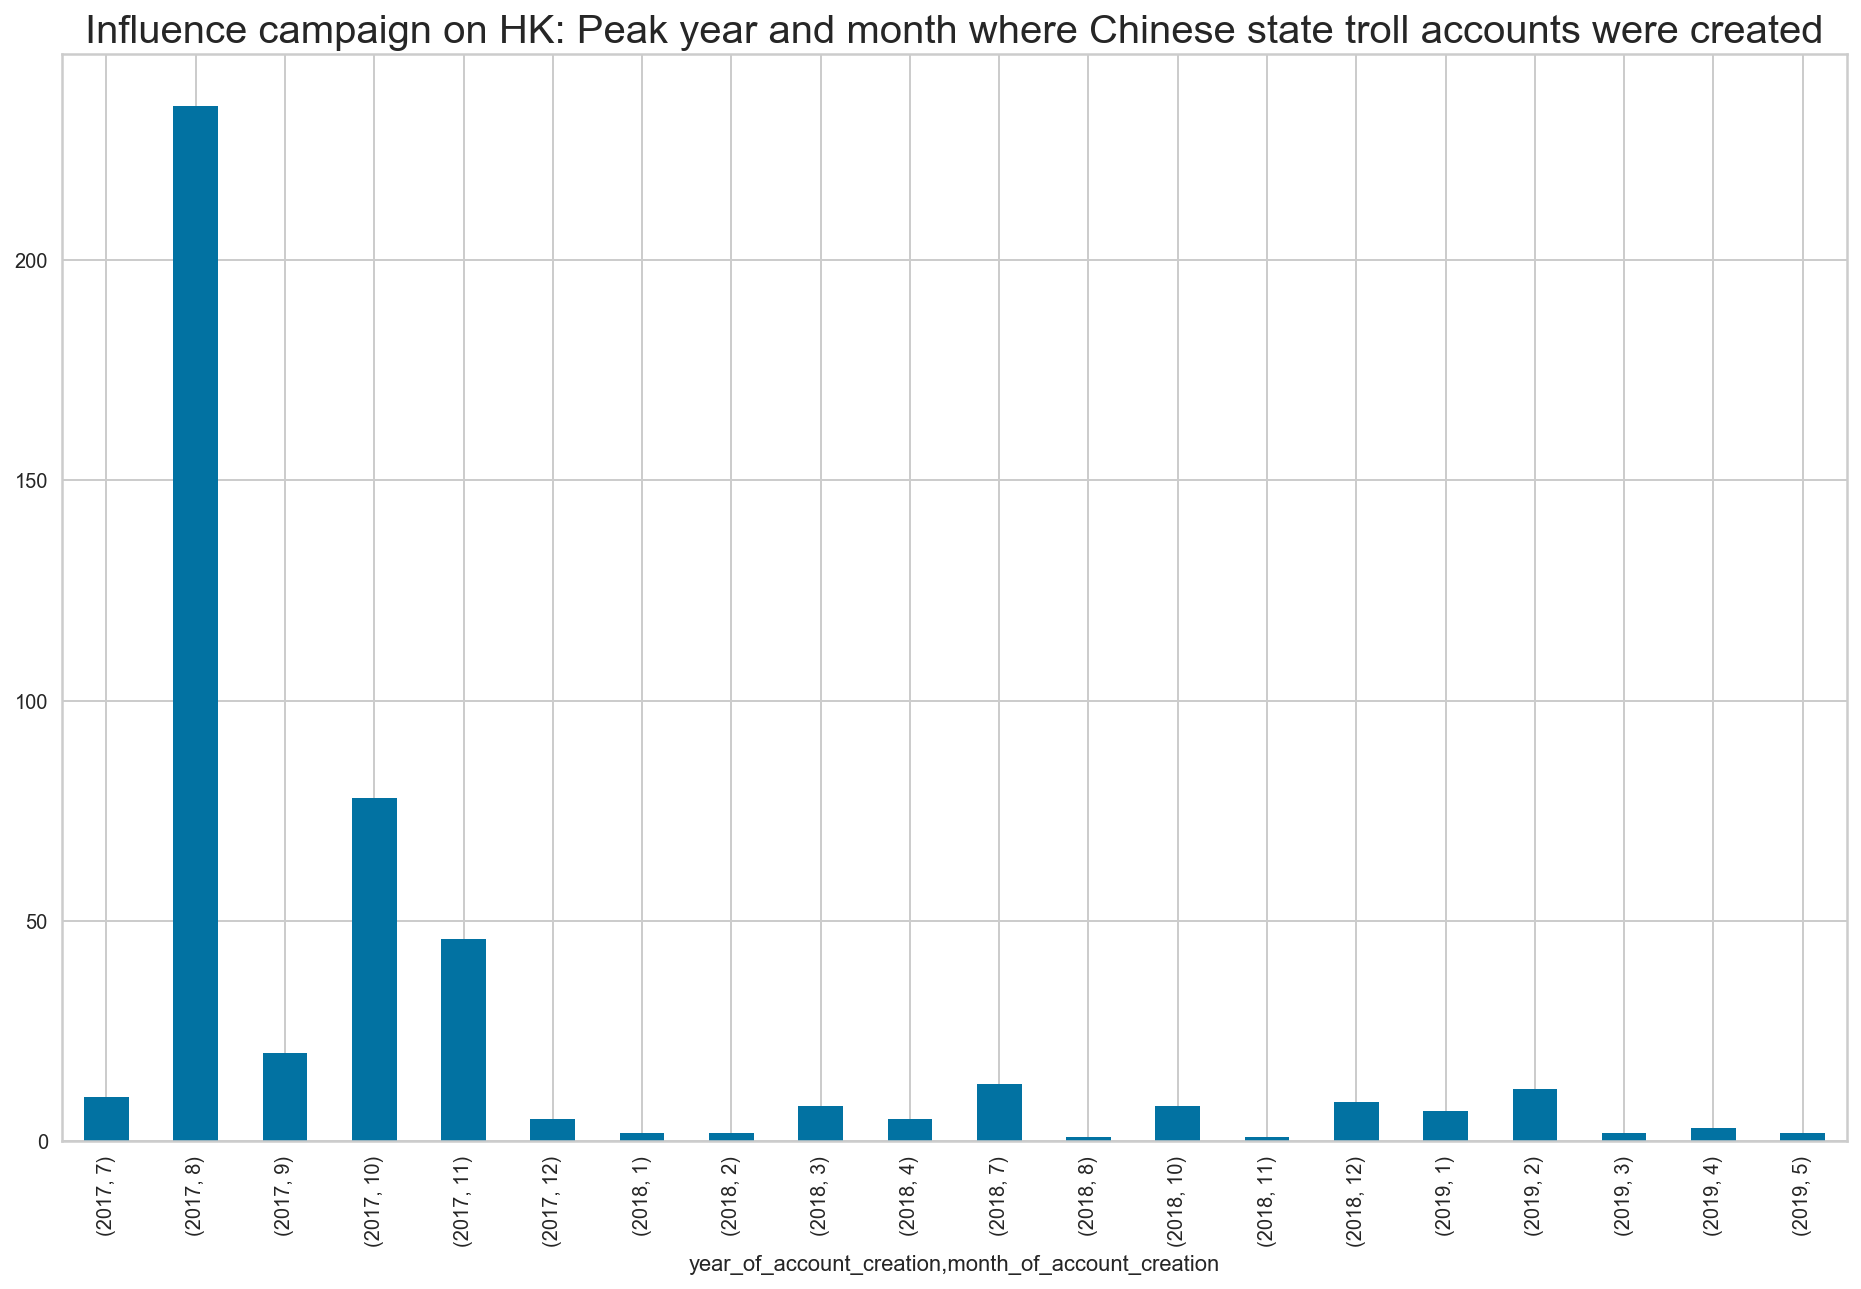

In [41]:
raw.groupby(['year_of_account_creation', 'month_of_account_creation']).userid.nunique().tail(20).plot(kind='bar', figsize=(16,10))
plt.title('Influence campaign on HK: Peak year and month where Chinese state troll accounts were created', fontsize=20)
plt.show()

## 4.2 TWEET TIME 
Did the Chinese state troll accounts step up their tweets as the protests escalated over the years?

In [42]:
# Converting timings to HK time
raw['tweet_time'] = pd.to_datetime(raw['tweet_time'])
raw['tweet_time'] = raw['tweet_time'].dt.tz_localize('GMT').dt.tz_convert('Hongkong')

In [43]:
raw['tweet_year'] = raw['tweet_time'].dt.year

In [44]:
raw['tweet_month'] = raw['tweet_time'].dt.month

In [45]:
raw['tweet_day'] = raw['tweet_time'].dt.day

In [46]:
# Tweet activity peaked in 2017, while 2019 was third most active
raw['tweet_year'].value_counts()

2017    204358
2018    166286
2019     58887
2016     48117
2015     38873
2013     28832
2014     27684
2012      5485
2010      1238
2011      1041
2009       265
2008         4
Name: tweet_year, dtype: int64

In [47]:
raw.groupby(['tweet_year', 'tweet_month']).tweet_text.nunique().sort_index(ascending=False).head(30)

tweet_year  tweet_month
2019        7               2928
            6               6313
            5               7462
            4               6895
            3               8158
            2               7194
            1              10607
2018        12             13875
            11             12751
            10             13848
            9               8860
            8               4804
            7               4718
            6               5323
            5               4940
            4               8007
            3              12418
            2              20566
            1              13515
2017        12             52553
            11             43879
            10              9251
            9               3045
            8                101
            7               1518
            6               7300
            5              19630
            4              19395
            3              17035
            2      

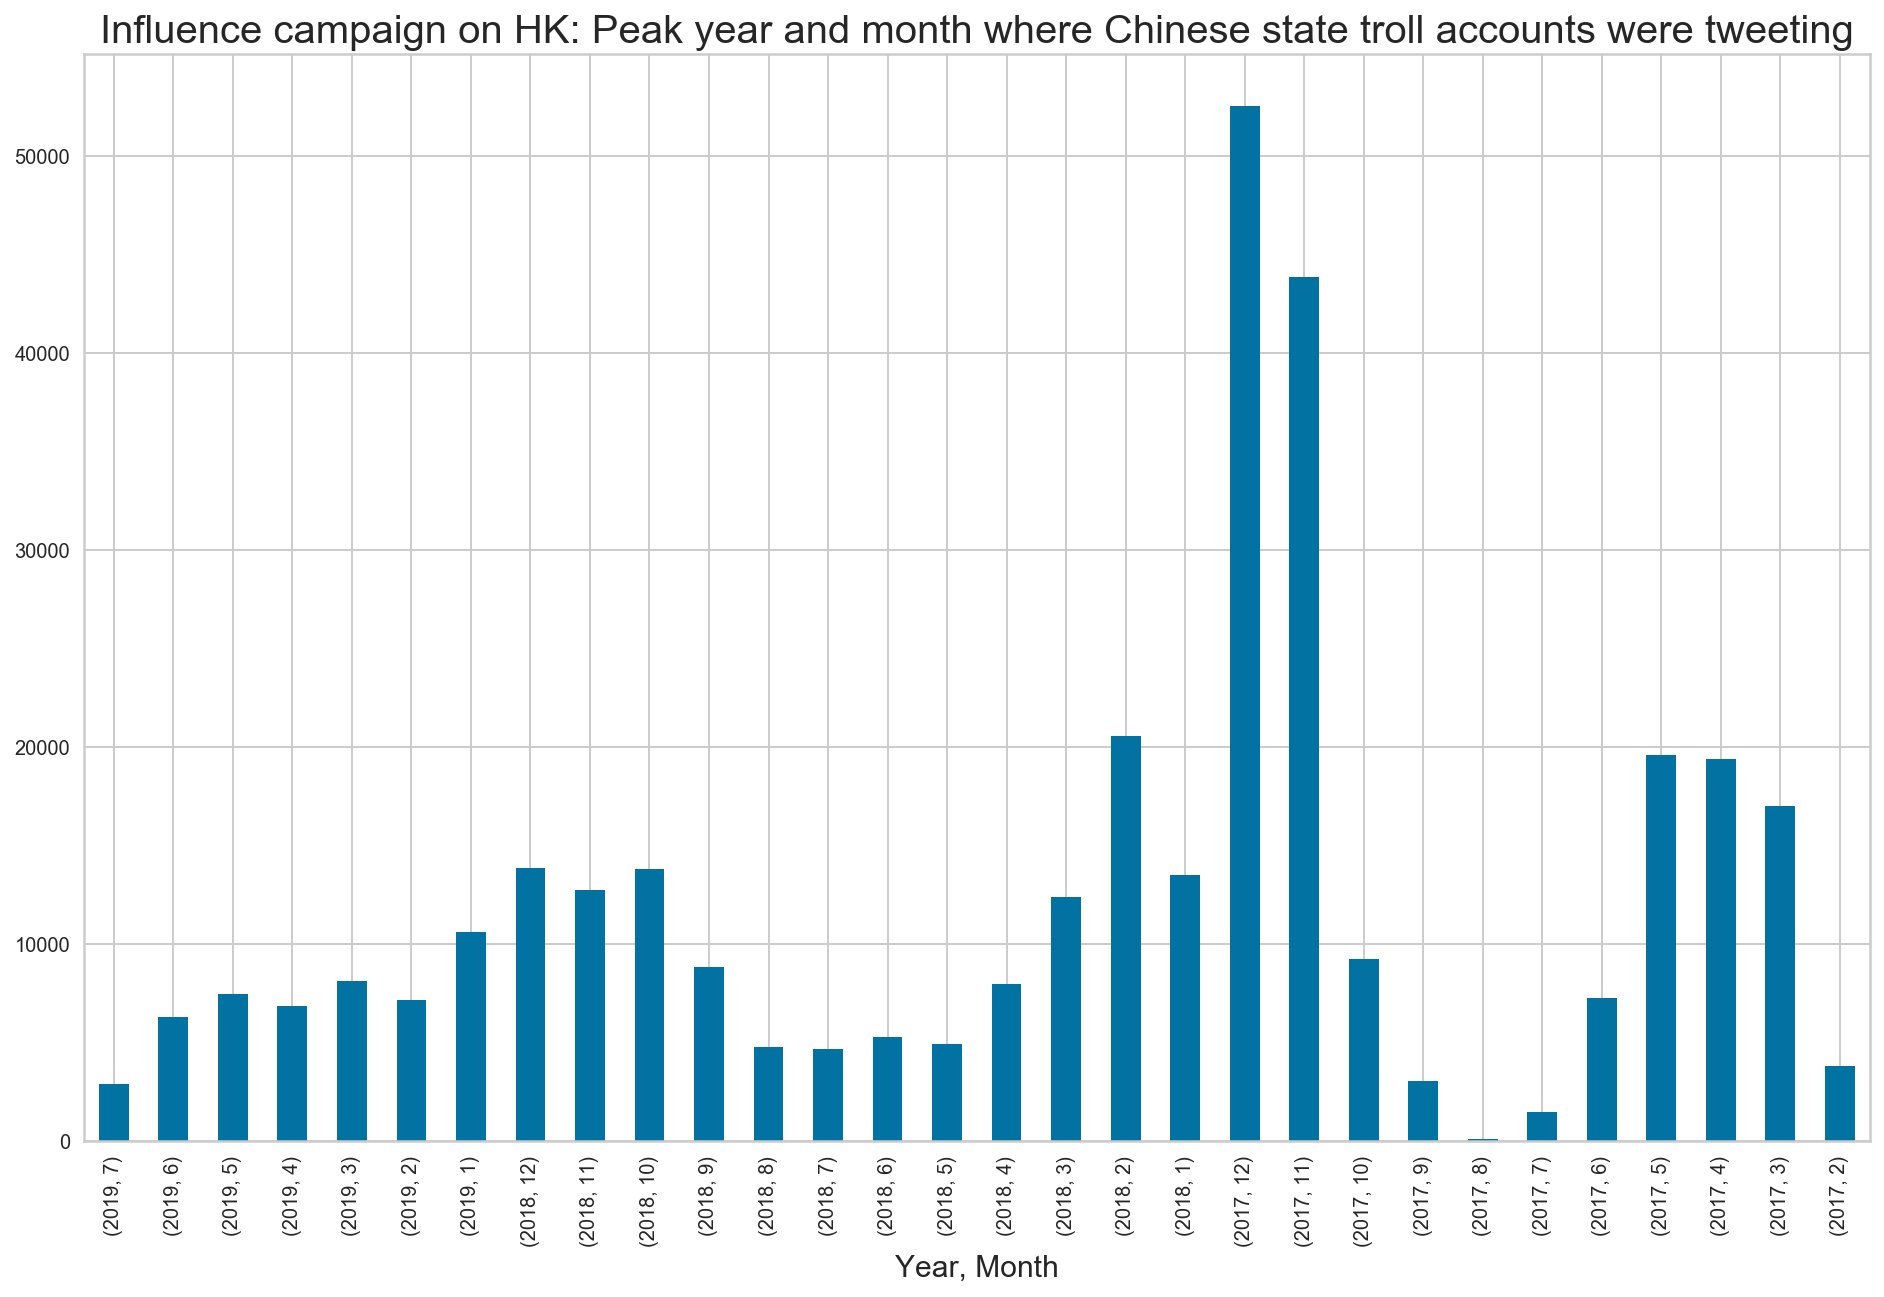

In [48]:
raw.groupby(['tweet_year', 'tweet_month']).tweet_text.nunique().sort_index(ascending=False).head(30).plot(kind='bar', figsize=(16,10))
plt.title('Influence campaign on HK: Peak year and month where Chinese state troll accounts were tweeting', fontsize=20)
plt.xlabel("Year, Month", fontsize=15)
plt.show()

# 5. CLEANING UP TWEET_TEXT COL
I'll keep the original tweet text column for reference, and create a newly cleaned column with punctuation etc taken out for the English NLP portion of the analysis.

In [49]:
# Function to clean tweets for punctuation and special characters
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub("\W", " ", text)
    text = re.sub("\s+", " ", text)
    text = text.strip(" ")
    text = text.strip("\n")
    text = re.sub("[^\w\s]", "", text)
    return text

In [50]:
raw['clean_tweet_text'] = raw['tweet_text'].map(lambda tweet: clean_tweet(tweet))

In [51]:
# Quick count-vect check on key English terms in tweets
vect = CountVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
docs = vect.fit_transform(raw['clean_tweet_text'].dropna())
features = vect.get_feature_names()

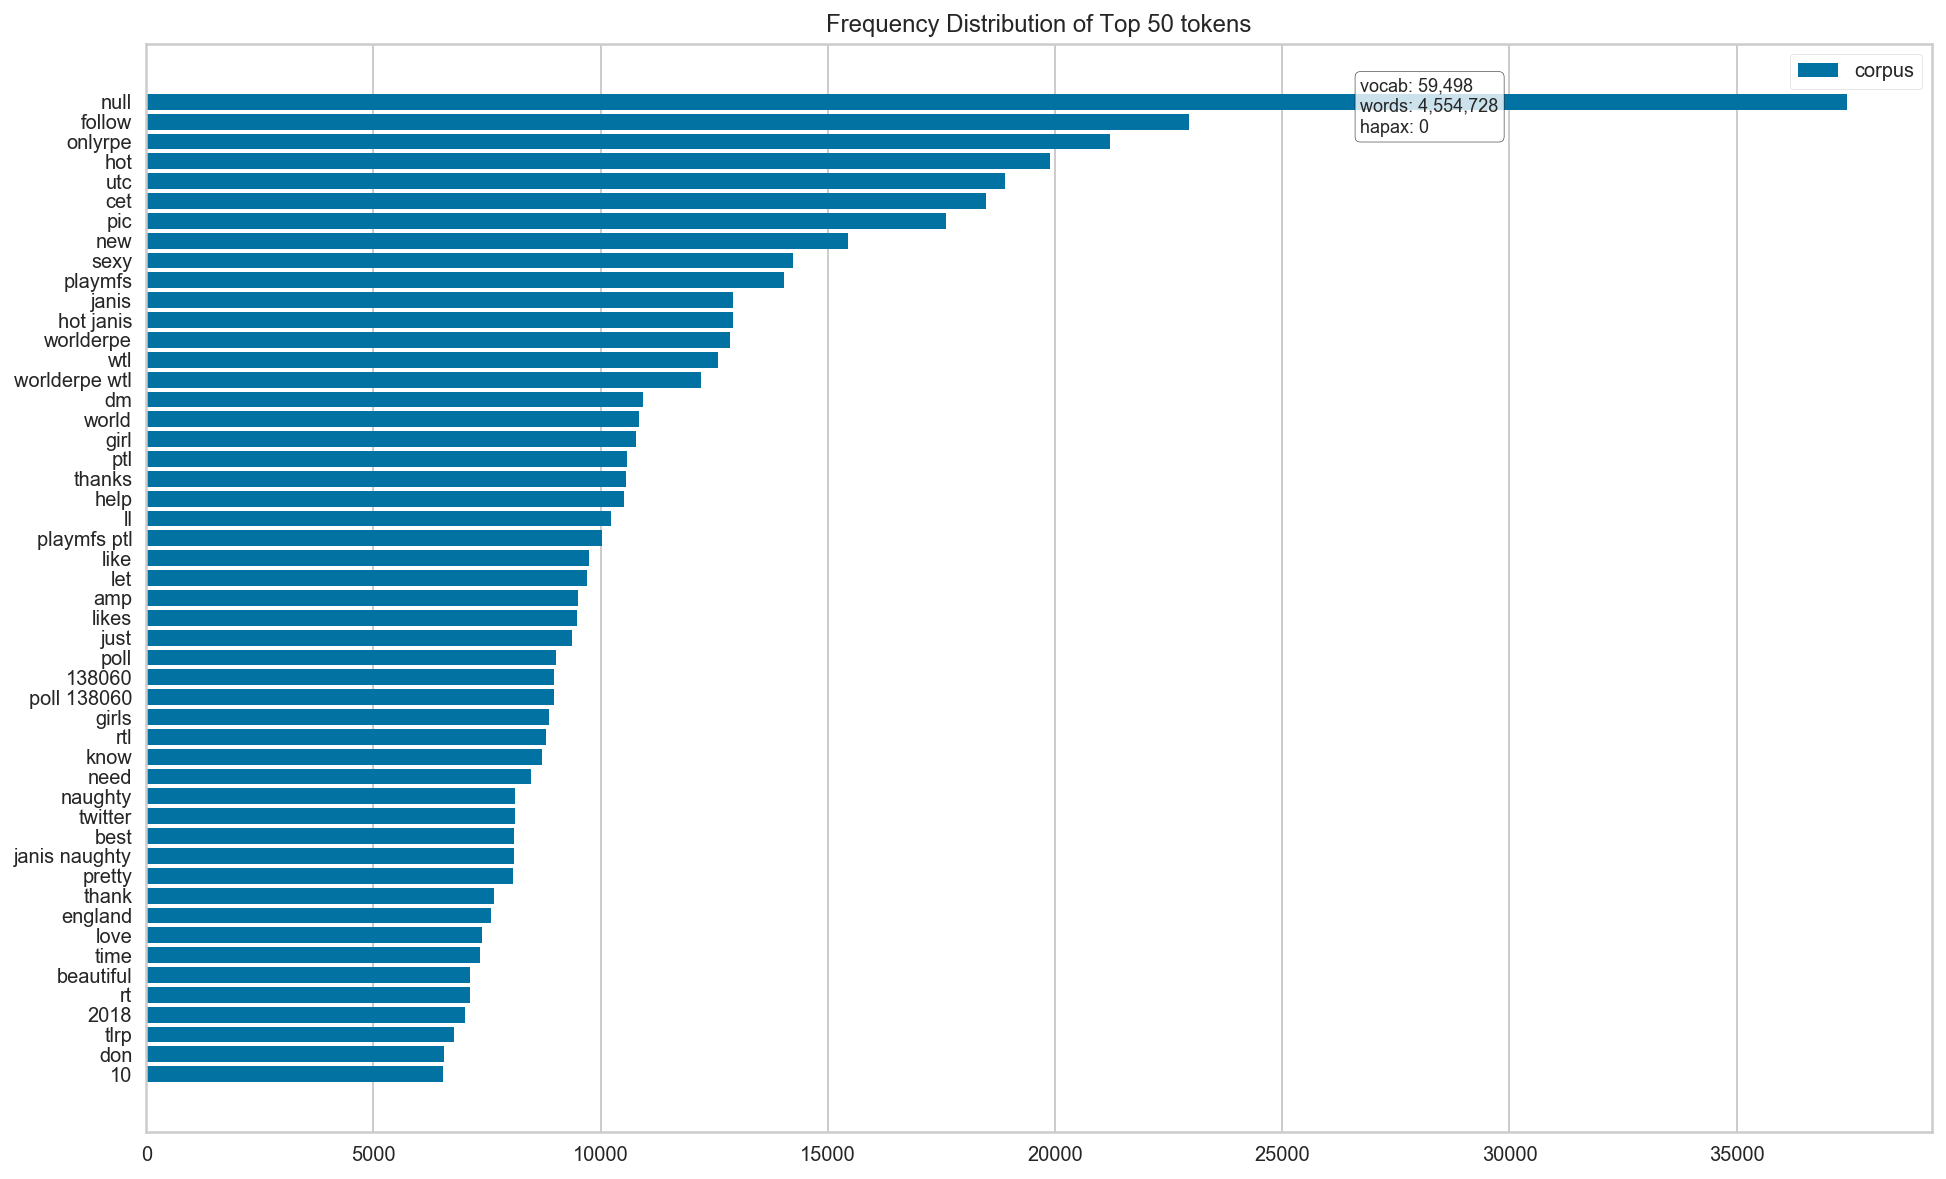

In [52]:
plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features)
visualiser.fit(docs)
visualiser.poof()
plt.show()

## END-NOTE:
A quick check suggests that there are a lot of junk words in the tweets which will have to be filtered out further.

The tweets in Chinese will have to be dealt with separately as well from the English ones. I'll continue this in a future notebook. This will have to suffice for now.

## 5.1 EXPORTING CURRENT DF FOR FUTURE ANALYSIS
Feel free to use the raw file or the semi-processed version that I'll output below:

In [53]:
hk = raw[
    [
        "tweetid",
        "user_screen_name",
        "user_display_name",        
        "user_reported_location",
        "user_profile_description",
        "follower_count",
        "following_count",
        "account_creation_date",
        "year_of_account_creation",
        "month_of_account_creation",
        "tweet_time",
        "tweet_year",
        "tweet_month",
        "tweet_day",
        "tweet_text",
        "clean_tweet_text",
        "hashtags",        
    ]
]

In [54]:
hk.head()

,tweetid,user_screen_name,user_display_name,user_reported_location,user_profile_description,follower_count,following_count,account_creation_date,year_of_account_creation,month_of_account_creation,tweet_time,tweet_year,tweet_month,tweet_day,tweet_text,clean_tweet_text,hashtags
15,587625750636822528,qujianming1,曲剑明,纽约布朗克斯,一个因言获罪的流浪者，我坚信光明一定会到来。,28405,24079,2012-06-28,2012,6,2015-04-13 22:37:00+08:00,2015,4,13,Test,test,[]
16,915099864521834497,qujianming1,曲剑明,纽约布朗克斯,一个因言获罪的流浪者，我坚信光明一定会到来。,28405,24079,2012-06-28,2012,6,2017-10-03 14:23:00+08:00,2017,10,3,new owner 💕,new owner,[]
26,802911206134550528,qujianming1,曲剑明,纽约布朗克斯,一个因言获罪的流浪者，我坚信光明一定会到来。,28405,24079,2012-06-28,2012,6,2016-11-28 00:25:00+08:00,2016,11,28,Makin gembrot. Amin https://t.co/EIwjBoUAPV,makin gembrot amin,[]
29,445070245011542016,qujianming1,曲剑明,纽约布朗克斯,一个因言获罪的流浪者，我坚信光明一定会到来。,28405,24079,2012-06-28,2012,6,2014-03-16 13:33:00+08:00,2014,3,16,"#openfollow for rp,retweet",openfollow for rp retweet,['openfollow']
46,598854583281004544,qujianming1,曲剑明,纽约布朗克斯,一个因言获罪的流浪者，我坚信光明一定会到来。,28405,24079,2012-06-28,2012,6,2015-05-14 22:17:00+08:00,2015,5,14,Test,test,[]


In [55]:
#hk.to_csv('../data/hk.csv', index=False)